This project is aiming on using the PINN for sound field reproduciton with 3d scanned geoemtry.


$$u_t + \lambda_{1}(uu_x + vu_y) = -p_x + \lambda_{2}(u_{xx} + u_{yy}), v_t + \lambda_{1}(uv_x + vv_y) = -p_y + \lambda_{2}(v_{xx} + v_{yy}),$$

where $u(t, x, y)$ and $v(t, x, y)$ are the x and y components of the velocity field, and $p(t, x, y)$ is the pressure, we seek the unknowns $\lambda = (\lambda_1, \lambda_2)$. When required, we integrate the constraints:

$$ 0 = u_x + v_y, u = \psi_y, v = -\psi_x,$$

We use a dual-output neural network to approximate $[\psi(t, x, y), p(t, x, y)]$, leading to a physics-informed neural network $[f(t, x, y), g(t, x, y)]$. 



### Problem Setup 

| Continuous Inverse Navier-Stokes Equation | |
|------------------------------|---|
| PDE equations | $f =  u_t + \lambda_1 (u u_x + v u_y) + p_x - \lambda_2  (u_{xx} + u_{yy}), g = v_t + \lambda_1 (u v_x + v  v_y) + p_y - \lambda_2  (v_{xx} + v_{yy})$ |
| Assumptions | $u = \psi_y, v = -\psi_x$ |
| The output of net | $[\psi(t, x, y), p(t, x, y)]$ |
| Layers of net | $[3] + 8 \times [20] +[2]$ |
| Sample count from collection points | $5000^*$ |
| Sample count from solution | $5000^*$ |
| Loss function | $\text{SSE}_s  + \text{SSE}_c$ |
\* Same points used for collocation and solutions.


The reason we use PINN is to reduce the computational time of a direct solution. we aim to find a PINN network model to reduce the full NS function into a NN calculation. Hence, a general training shall be using the PINN for the point sound pressure prediction. 

The training process shall be,
With the given geometry, and the input microphone array sound pressure, it can return the surface sound pressure (SSP)

Training data set shall be obtained by the simplest synario, and then the training datas will be simplified.

The process shall also take consideration of convex optimization, that we could use limited observation point to represent the entire system and find the limited source location. 

This method is already been well evaluated and is called CS-DL (compressive sensing - deep learning) methods, it shall be used in 

The reconstruction of CS depending on the sparse structure of the signal, PINN does the same, it gives additional constraints that the singal must be fulfill the physical law. Hence the question becomes to how to combine these two methods togther.

In [1]:
# Step 1: Set Up the Environment
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# For PDE solving and automatic differentiation
from torch.autograd import grad

# Set device (CPU or GPU)
torch.set_float32_matmul_precision('medium')
device = torch.device('cuda')


In [2]:
torch.cuda.is_available()

True

In [3]:
# Step 2: Implement the CS Reconstruction Module (LAMP)

class LAMPlayer(nn.Module):
    def __init__(self, sensing_matrix, num_layers, shrinkage='soft'):
        super(LAMPlayer, self).__init__()
        self.num_layers = num_layers
        self.sensing_matrix = sensing_matrix.to(device)
        self.sensing_matrix_t = sensing_matrix.t().to(device)
        self.theta = nn.ParameterList()
        self.shrinkage = shrinkage

        # Initialize learnable parameters for each layer
        for _ in range(num_layers):
            self.theta.append(nn.Parameter(torch.Tensor([0.1])))
    
    def forward(self, y):
        # Initialize variables
        a = torch.zeros(self.sensing_matrix.shape[1], y.shape[1]).to(device)
        r = y.clone().to(device)
        
        for t in range(self.num_layers):
            # Linear step
            z = a + self.sensing_matrix_t @ r
            # Non-linear step (Learned shrinkage)
            a = self.shrinkage_function(z, self.theta[t])
            # Residual update
            r = y - self.sensing_matrix @ a
            # Optional: Include Onsager correction term if needed
        return a

    def shrinkage_function(self, x, theta):
        if self.shrinkage == 'soft':
            return torch.sign(x) * torch.relu(torch.abs(x) - theta)
        else:
            # Implement other shrinkage functions if needed
            return x


In [4]:
# Step 3: Implement the PINN Module

class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_hidden_layers):
        super(PINN, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.Tanh())
        for _ in range(num_hidden_layers):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [5]:
# Step 4: Integrate Both Modules

class CS_PINN_Model(nn.Module):
    def __init__(self, sensing_matrix, num_lamp_layers, pinn_params):
        super(CS_PINN_Model, self).__init__()
        self.lamp = LAMPlayer(sensing_matrix, num_lamp_layers)
        self.pinn = PINN(**pinn_params)
    
    def forward(self, y, x_pinn):
        # CS Reconstruction
        a_init = self.lamp(y)
        # Map sparse coefficients to initial pressure field estimate
        # Assuming basis functions are available
        p_init = self.basis_functions(x_pinn, a_init)
        # PINN Refinement
        p_pred = self.pinn(x_pinn)
        return p_pred, a_init
    
    def basis_functions(self, x, a):
        # Implement the mapping from coefficients to pressure field
        # For simplicity, assume Fourier basis or other suitable basis
        # x: (N_samples, input_dim)
        # a: (num_basis, batch_size)
        # Return: p_init (N_samples, 1)
        # Placeholder implementation:
        return torch.zeros(x.shape[0], 1).to(device)


In [6]:
def loss_function(model, y, x_pinn, x_boundary, p_boundary, lambda_cs, lambda_pde, lambda_boundary):
    # Forward pass
    p_pred, a_init = model(y, x_pinn)
    
    # CS Reconstruction Loss (Data Fidelity)
    y_pred = model.lamp.sensing_matrix @ a_init
    cs_loss = nn.MSELoss()(y_pred, y)
    
    # PDE Residual Loss (Physics Loss)
    # No need to set p_pred.requires_grad_(True) here
    # Compute gradients for PDE residual
    grad_p = grad(p_pred, x_pinn, torch.ones_like(p_pred), create_graph=True)[0]
    laplacian_p = torch.zeros_like(p_pred).to(device)
    for i in range(x_pinn.shape[1]):
        grad_p_i = grad(grad_p[:, i], x_pinn, torch.ones_like(grad_p[:, i]), create_graph=True)[0][:, i]
        laplacian_p += grad_p_i.unsqueeze(1)
    # Helmholtz Equation Residual: ∇²p + k²p = 0
    k = 2 * np.pi / 0.1  # Example wavenumber
    pde_residual = laplacian_p + (k ** 2) * p_pred
    pde_loss = torch.mean(pde_residual ** 2)
    
    # Boundary Condition Loss
    p_boundary_pred = model.pinn(x_boundary)
    boundary_loss = nn.MSELoss()(p_boundary_pred, p_boundary)
    
    # Total Loss
    total_loss = lambda_cs * cs_loss + lambda_pde * pde_loss + lambda_boundary * boundary_loss
    return total_loss, cs_loss.item(), pde_loss.item(), boundary_loss.item()


In [7]:
# Step 6: Training Loop

# Hyperparameters
num_epochs = 10000
learning_rate = 1e-3
lambda_cs = 1.0
lambda_pde = 1.0
lambda_boundary = 1.0

# Model Parameters
sensing_matrix = torch.randn(36, 1000)  # Example sensing matrix
num_lamp_layers = 10
pinn_params = {
    'input_dim': 3,
    'hidden_dim': 50,
    'output_dim': 1,
    'num_hidden_layers': 4
}

# Instantiate Model
model = CS_PINN_Model(sensing_matrix, num_lamp_layers, pinn_params).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Data (Placeholders)
# y: Microphone measurements (36, batch_size)
# x_pinn: Collocation points for PDE residual (N_samples, 3)
# x_boundary: Boundary points from LiDAR (N_boundary, 3)
# p_boundary: Boundary pressure values (N_boundary, 1)

# For illustration purposes, let's create some synthetic data
batch_size = 1  # For simplicity
y = torch.randn(36, batch_size).to(device)

# Enable gradients for x_pinn
x_pinn = torch.randn(1000, 3, requires_grad=True).to(device)

x_boundary = torch.randn(200, 3).to(device)
p_boundary = torch.zeros(200, 1).to(device)  # Assuming zero boundary condition

# Training Loop
for epoch in range(num_epochs):
    optimizer.zero_grad()
    total_loss, cs_loss, pde_loss, boundary_loss = loss_function(
        model, y, x_pinn, x_boundary, p_boundary, lambda_cs, lambda_pde, lambda_boundary)
    total_loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Total Loss={total_loss.item():.6f}, CS Loss={cs_loss:.6f}, PDE Loss={pde_loss:.6f}, Boundary Loss={boundary_loss:.6f}")


c:\ProgramData\anaconda3\envs\myenv\Lib\site-packages\torch\autograd\graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0: Total Loss=inf, CS Loss=inf, PDE Loss=14906.867188, Boundary Loss=0.000933
Epoch 100: Total Loss=nan, CS Loss=nan, PDE Loss=3.709313, Boundary Loss=0.000000
Epoch 200: Total Loss=nan, CS Loss=nan, PDE Loss=1.663771, Boundary Loss=0.000000
Epoch 300: Total Loss=nan, CS Loss=nan, PDE Loss=1.127248, Boundary Loss=0.000000
Epoch 400: Total Loss=nan, CS Loss=nan, PDE Loss=0.878232, Boundary Loss=0.000000
Epoch 500: Total Loss=nan, CS Loss=nan, PDE Loss=0.714966, Boundary Loss=0.000000
Epoch 600: Total Loss=nan, CS Loss=nan, PDE Loss=0.589077, Boundary Loss=0.000000
Epoch 700: Total Loss=nan, CS Loss=nan, PDE Loss=0.488341, Boundary Loss=0.000000
Epoch 800: Total Loss=nan, CS Loss=nan, PDE Loss=0.407813, Boundary Loss=0.000000
Epoch 900: Total Loss=nan, CS Loss=nan, PDE Loss=0.340791, Boundary Loss=0.000000
Epoch 1000: Total Loss=nan, CS Loss=nan, PDE Loss=0.288520, Boundary Loss=0.000000
Epoch 1100: Total Loss=nan, CS Loss=nan, PDE Loss=0.245856, Boundary Loss=0.000000
Epoch 1200: 

In [8]:
# Create a grid of points in the x-y plane at z=0
x_range = np.linspace(-1, 1, 100)
y_range = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x_range, y_range)
Z = np.zeros_like(X)
grid_points = np.vstack((X.flatten(), Y.flatten(), Z.flatten())).T
grid_points_torch = torch.tensor(grid_points, dtype=torch.float32).to(device)


In [9]:
# Parameters
A = 1.0         # Amplitude
frequency = 10  # Frequency in Hz
c = 340         # Speed of sound in m/s
omega = 2 * np.pi * frequency  # Angular frequency
k = omega / c   # Wavenumber

# Compute true pressure at microphone positions
def compute_pressure(x):
    r = np.linalg.norm(x, axis=1, keepdims=True)
    p = A * np.exp(1j * k * r) / r
    return np.real(p)


In [10]:
# Compute true pressure at grid points
p_true = compute_pressure(grid_points)
p_true = p_true.reshape(X.shape)


In [13]:
# Model Prediction
model.eval()
with torch.no_grad():
    p_pred = model.pinn(grid_points_torch).cpu().numpy().reshape(X.shape)


AttributeError: 'Tensor' object has no attribute 'gpu'

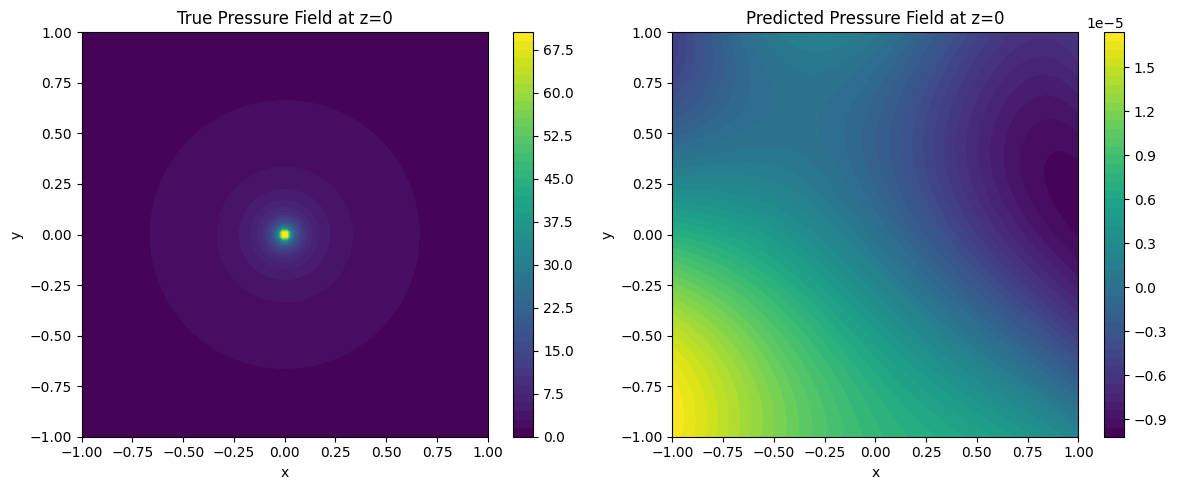

In [12]:
import matplotlib.pyplot as plt

# True Pressure Field
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.contourf(X, Y, p_true, levels=50, cmap='viridis')
plt.colorbar()
plt.title('True Pressure Field at z=0')
plt.xlabel('x')
plt.ylabel('y')

# Predicted Pressure Field
plt.subplot(1, 2, 2)
plt.contourf(X, Y, p_pred, levels=50, cmap='viridis')
plt.colorbar()
plt.title('Predicted Pressure Field at z=0')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()
